In [1]:
'''This script demonstrates VAE on image data

 #Reference

 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
 - Joint Multi-Modal VAE
   https://arxiv.org/pdf/1611.01891.pdf
'''
import warnings
import os
from glob import glob
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab
plt.rcParams["figure.figsize"] = [20,20]
from scipy.stats import norm
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
import keras
from skimage.transform import resize
from PIL import Image

import sys, os
sys.path.append(os.path.expanduser('/opt/repositories/twbserver_notebook/notebook/tools'))
import vae_tools
from vae_tools import plot_model, layers, nb_tools, viz, loader, build_model, sanity, sampling, custom_variational_layer

nb_tools.notebook_resize()
sanity.check()


Using TensorFlow backend.


python version:  3.5.2
keras version: 2.2.4
tensorflow version: 1.13.1
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


In [2]:

def get_iterator(batch_size):
    from keras.preprocessing.image import ImageDataGenerator
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0)  # randomly shift images vertically (fraction of total height))

    train_generator = train_datagen.flow_from_directory('img_0', interpolation='nearest',
            color_mode='rgb', shuffle=False, seed=None,
            target_size=(60, 80),
            batch_size=batch_size,
            #save_to_dir='img_0_augmented',
            class_mode=None)
    return train_generator
X_train = get_iterator(1710).next()

Found 1710 images belonging to 1 classes.


Found 1710 images belonging to 1 classes.
(60, 80, 3)


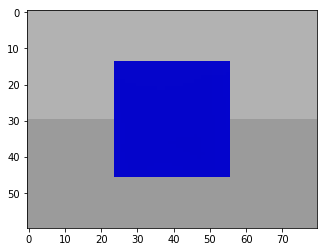

In [3]:
# Show some scaled image
x = get_iterator(1).next()
print(x[0].shape)
plt.imshow(x[0])
plt.show()

In [4]:
# input image dimensions and config
use_conv = False
batch_size = 128
image_rows_cols_chns = (60, 80, 3)
original_dim = np.prod(image_rows_cols_chns)
latent_dim = 2
intermediate_dim = 256 # former 128
intermediate_dim_2 = int(intermediate_dim / 2)
epochs = 4000
save_model = False
#beta = 0.012207031 # 50.
beta = 1.

if use_conv:
    # number of convolutional filters to use
    filters = 32 # former 64
    # convolution kernel size
    num_conv = 3
    # Other values
    rows = image_rows_cols_chns[0]
    rows_2 = int(rows/2)
    cols = image_rows_cols_chns[1]
    cols_2 = int(cols/2)
    img_chns = image_rows_cols_chns[2]
    if keras.backend.image_data_format() == 'channels_first':
        original_img_size = (image_rows_cols_chns[2], image_rows_cols_chns[0], image_rows_cols_chns[1])
        output_shape_reshape = (batch_size, filters, rows_2, cols_2)
        output_shape_upsamp = (batch_size, filters, rows+1, cols+1)
    else:
        original_img_size = image_rows_cols_chns
        output_shape_reshape = (batch_size, rows_2, cols_2, filters)
        output_shape_upsamp = (batch_size, rows+1, cols+1, filters)
else:
    # Reshape the data
    X_train = X_train.reshape(len(X_train),np.prod(X_train.shape[1:]))

if use_conv:
    encoder = [[
        Input(shape=original_img_size),
        Conv2D(img_chns, kernel_size=(2, 2), padding='same', activation='relu'),
        Conv2D(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2)),
        Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
        Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
        Flatten(),
        Dense(intermediate_dim, activation='relu')
    ]]
    
    decoder = [[
        Dense(intermediate_dim, activation='relu'),
        Dense(filters * rows_2 * cols_2, activation='relu'),
        Reshape(output_shape_reshape[1:]),
        Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
        Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
        Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu'),
        Conv2D(img_chns, kernel_size=2, padding='valid', activation='sigmoid')
    ]]

else:
    encoder = [[
        Input(shape=(original_dim,)),
        Dense(intermediate_dim, activation='relu'),
        Dense(intermediate_dim_2, activation='relu')
    ]]
    
    decoder = [[
        Dense(intermediate_dim_2, activation='relu'),
        Dense(intermediate_dim, activation='relu'),
        Dense(original_dim, activation='sigmoid')
    ]]
    

Instructions for updating:
Colocations handled automatically by placer.
Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14400)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          3686656     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            258         dense_2[0][0] 

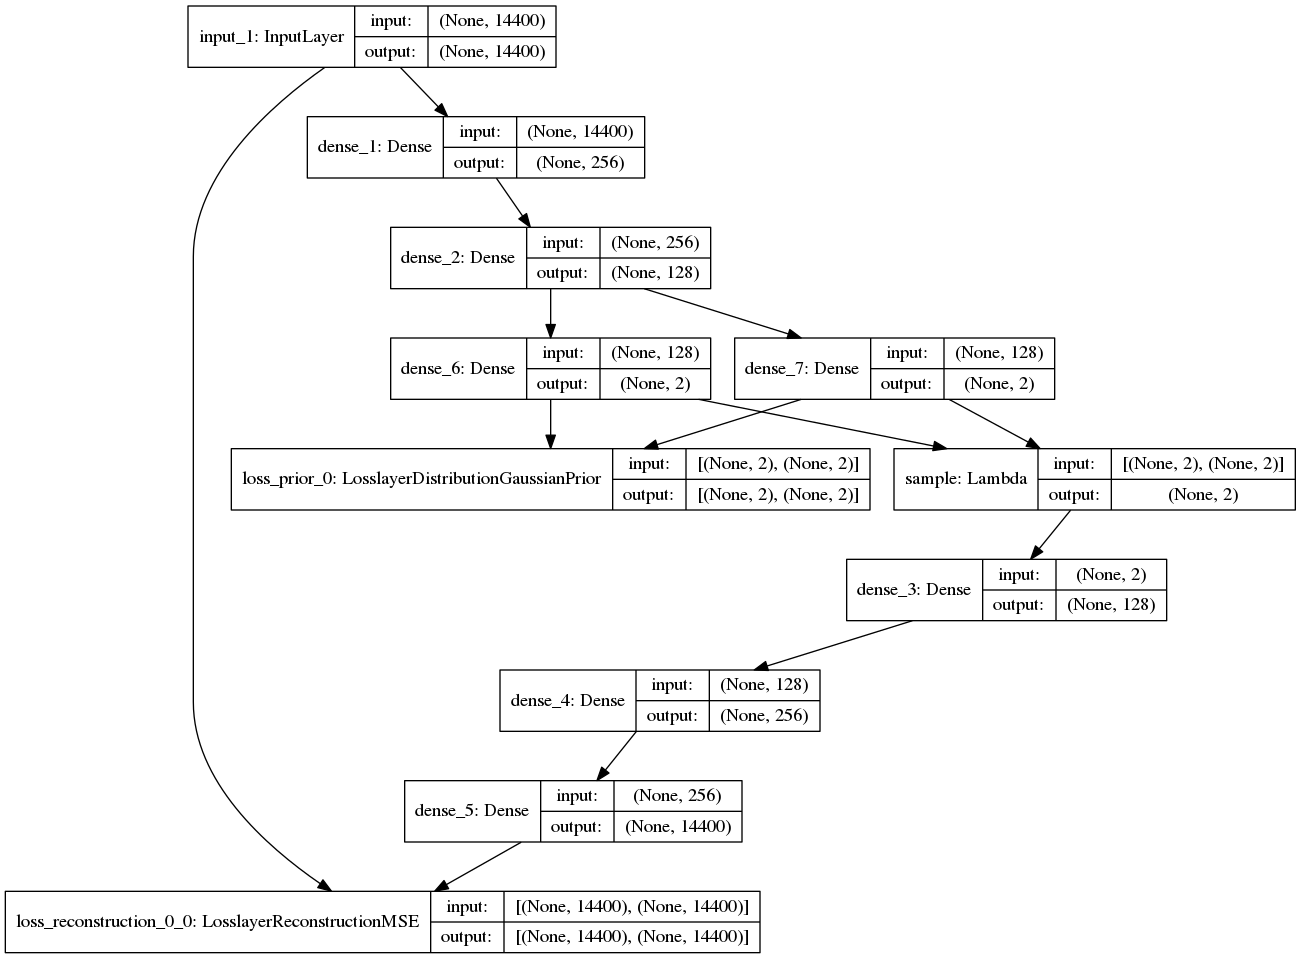

In [5]:
model_obj = vae_tools.mmvae.MmVae(latent_dim, encoder, decoder, [original_dim], beta, beta_is_normalized = False, reconstruction_loss_metrics = [vae_tools.mmvae.ReconstructionLoss.MSE], name='Vae')
vae = model_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [6]:
# Show some examples
#viz.random_images_from_set(X_set, image_rows_cols_chns, n = 15);

In [7]:
# Train
vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/4000
1710/1710 [==============================] - 3s 2ms/step - loss: 830750309.2868
Epoch 2/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 508.7065
Epoch 3/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 508.6756
Epoch 4/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 477.8243
Epoch 5/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 469.9342
Epoch 6/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 418.8427
Epoch 7/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 365.0329
Epoch 8/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 367.6699
Epoch 9/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 360.5814
Epoch 10/4000
1710/1710 [==============================] - 3s 2ms/step - loss: 350.8023
Epoch 11/4000
1710/1710 [==============================] - 3s 2ms/step - lo

1710/1710 [==============================] - 2s 1ms/step - loss: 140.1098
Epoch 92/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 136.9235
Epoch 93/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 144.0525
Epoch 94/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 139.3259
Epoch 95/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 140.4014
Epoch 96/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 137.9859
Epoch 97/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 140.2392
Epoch 98/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 135.0019
Epoch 99/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 143.1186
Epoch 100/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 139.9050
Epoch 101/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 137.6628
Epoch 102/4000
1710/1710 [==================

1710/1710 [==============================] - 2s 1ms/step - loss: 121.7207
Epoch 184/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 119.0477
Epoch 185/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 119.7384
Epoch 186/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 117.6493
Epoch 187/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 120.8434
Epoch 188/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 119.4596
Epoch 189/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 116.9665
Epoch 190/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 117.1685
Epoch 191/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 118.4717
Epoch 192/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 121.0172
Epoch 193/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 116.8247
Epoch 194/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 109.9290
Epoch 276/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 109.2110
Epoch 277/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 107.4515
Epoch 278/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 108.8139
Epoch 279/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 110.1197
Epoch 280/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 106.8604
Epoch 281/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 108.4334
Epoch 282/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 108.6557
Epoch 283/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 108.7988
Epoch 284/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 107.9142
Epoch 285/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 106.0103
Epoch 286/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 99.2649
Epoch 368/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 101.4602
Epoch 369/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 99.6474
Epoch 370/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 101.4276
Epoch 371/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 99.9973
Epoch 372/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 101.0466
Epoch 373/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 99.7461
Epoch 374/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 101.0315
Epoch 375/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 101.2456
Epoch 376/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 99.6286
Epoch 377/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 99.4479
Epoch 378/4000
1710/1710 [================

1710/1710 [==============================] - 2s 1ms/step - loss: 92.2640
Epoch 461/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 95.4527
Epoch 462/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 96.8752
Epoch 463/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 91.5819
Epoch 464/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 95.2065
Epoch 465/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 91.6985
Epoch 466/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 95.1073
Epoch 467/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 94.8353
Epoch 468/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 91.7414
Epoch 469/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 92.7072
Epoch 470/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 95.3157
Epoch 471/4000
1710/1710 [=====================

1710/1710 [==============================] - 2s 1ms/step - loss: 86.3797
Epoch 554/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 89.7548
Epoch 555/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 89.3077
Epoch 556/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 87.3361
Epoch 557/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 90.0140
Epoch 558/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 86.3575
Epoch 559/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 90.2254
Epoch 560/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 85.8907
Epoch 561/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 89.0053
Epoch 562/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 88.6048
Epoch 563/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 87.3855
Epoch 564/4000
1710/1710 [=====================

1710/1710 [==============================] - 2s 1ms/step - loss: 83.9220
Epoch 647/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 81.8908
Epoch 648/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 85.4267
Epoch 649/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 82.1294
Epoch 650/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 82.7177
Epoch 651/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 83.7488
Epoch 652/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 82.6965
Epoch 653/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 83.7302
Epoch 654/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 83.2621
Epoch 655/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 79.6904
Epoch 656/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 84.8465
Epoch 657/4000
1710/1710 [=====================

1710/1710 [==============================] - 2s 1ms/step - loss: 80.9442
Epoch 740/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 75.9264
Epoch 741/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 81.2539
Epoch 742/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 77.8206
Epoch 743/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 79.3123
Epoch 744/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 77.3590
Epoch 745/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 81.0883
Epoch 746/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 77.7479
Epoch 747/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 79.6285
Epoch 748/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 75.9585
Epoch 749/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 79.2516
Epoch 750/4000
1710/1710 [=====================

1710/1710 [==============================] - 2s 1ms/step - loss: 75.4489
Epoch 833/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 76.9091
Epoch 834/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 73.8558
Epoch 835/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 76.3495
Epoch 836/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 76.8939
Epoch 837/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 76.1530
Epoch 838/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 73.4387
Epoch 839/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 74.8872
Epoch 840/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 74.6580
Epoch 841/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 76.3955
Epoch 842/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 77.0426
Epoch 843/4000
1710/1710 [=====================

1710/1710 [==============================] - 3s 2ms/step - loss: 71.7731
Epoch 926/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 70.8202
Epoch 927/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 74.4532
Epoch 928/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 70.7972
Epoch 929/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 71.9630
Epoch 930/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 74.4568
Epoch 931/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 70.1709
Epoch 932/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 71.9745
Epoch 933/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 74.2135
Epoch 934/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 73.5418
Epoch 935/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 71.0320
Epoch 936/4000
1710/1710 [=====================

1710/1710 [==============================] - 2s 1ms/step - loss: 70.8317
Epoch 1019/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 69.7903
Epoch 1020/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 69.2061
Epoch 1021/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 71.9206
Epoch 1022/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 68.5656
Epoch 1023/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 69.7180
Epoch 1024/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 71.9843
Epoch 1025/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 68.8959
Epoch 1026/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 71.0655
Epoch 1027/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 70.9112
Epoch 1028/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 69.1598
Epoch 1029/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 69.6384
Epoch 1111/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.5152
Epoch 1112/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 68.6374
Epoch 1113/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.3509
Epoch 1114/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 71.2873
Epoch 1115/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.6948
Epoch 1116/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 68.2651
Epoch 1117/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 68.9794
Epoch 1118/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 65.1338
Epoch 1119/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 70.7428
Epoch 1120/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.4474
Epoch 1121/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 64.7998
Epoch 1203/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 65.7030
Epoch 1204/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.7860
Epoch 1205/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 65.0237
Epoch 1206/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 67.4483
Epoch 1207/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.8822
Epoch 1208/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.9486
Epoch 1209/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 65.6637
Epoch 1210/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.4721
Epoch 1211/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.7087
Epoch 1212/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 67.3457
Epoch 1213/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 64.8717
Epoch 1295/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 63.6718
Epoch 1296/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.4658
Epoch 1297/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.0897
Epoch 1298/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 67.9691
Epoch 1299/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.0589
Epoch 1300/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.4134
Epoch 1301/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.6124
Epoch 1302/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 65.2086
Epoch 1303/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 63.8162
Epoch 1304/4000
1710/1710 [==============================] - 3s 2ms/step - loss: 62.8849
Epoch 1305/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 64.4293
Epoch 1387/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.0373
Epoch 1388/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.3560
Epoch 1389/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 63.1464
Epoch 1390/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.0281
Epoch 1391/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.4602
Epoch 1392/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.4582
Epoch 1393/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.8686
Epoch 1394/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 65.0561
Epoch 1395/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 60.5897
Epoch 1396/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 65.6234
Epoch 1397/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 63.4490
Epoch 1479/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.7304
Epoch 1480/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.8500
Epoch 1481/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 66.0209
Epoch 1482/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.9096
Epoch 1483/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.8456
Epoch 1484/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 63.3338
Epoch 1485/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.3222
Epoch 1486/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.3748
Epoch 1487/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.1310
Epoch 1488/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.7845
Epoch 1489/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 60.7178
Epoch 1571/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.0361
Epoch 1572/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.4166
Epoch 1573/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 64.1508
Epoch 1574/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.4444
Epoch 1575/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.4300
Epoch 1576/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.9042
Epoch 1577/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.2088
Epoch 1578/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 60.6023
Epoch 1579/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.9590
Epoch 1580/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.8924
Epoch 1581/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 59.8180
Epoch 1663/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.5620
Epoch 1664/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.7973
Epoch 1665/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 60.4846
Epoch 1666/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.2278
Epoch 1667/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.0227
Epoch 1668/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 60.6071
Epoch 1669/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.9243
Epoch 1670/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.1668
Epoch 1671/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.1571
Epoch 1672/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.4079
Epoch 1673/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 60.9327
Epoch 1755/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.7565
Epoch 1756/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.0084
Epoch 1757/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.5210
Epoch 1758/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.7693
Epoch 1759/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 60.2513
Epoch 1760/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.9914
Epoch 1761/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 62.5078
Epoch 1762/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.2038
Epoch 1763/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.6194
Epoch 1764/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 60.7258
Epoch 1765/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 58.9968
Epoch 1847/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.9153
Epoch 1848/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.0428
Epoch 1849/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.4617
Epoch 1850/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.4966
Epoch 1851/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.2733
Epoch 1852/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.2901
Epoch 1853/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.3869
Epoch 1854/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 61.3339
Epoch 1855/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.9549
Epoch 1856/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.9169
Epoch 1857/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 57.8137
Epoch 1939/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.1842
Epoch 1940/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.1356
Epoch 1941/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.3529
Epoch 1942/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.6241
Epoch 1943/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.1582
Epoch 1944/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 59.2359
Epoch 1945/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.7250
Epoch 1946/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.6680
Epoch 1947/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.4697
Epoch 1948/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.9187
Epoch 1949/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 56.1442
Epoch 2031/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.3557
Epoch 2032/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.7475
Epoch 2033/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.6280
Epoch 2034/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.7829
Epoch 2035/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.7960
Epoch 2036/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.7440
Epoch 2037/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.7597
Epoch 2038/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.0862
Epoch 2039/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.5683
Epoch 2040/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.3389
Epoch 2041/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 55.2148
Epoch 2123/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.1228
Epoch 2124/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.7948
Epoch 2125/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.1927
Epoch 2126/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.8580
Epoch 2127/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.8394
Epoch 2128/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.6150
Epoch 2129/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.1118
Epoch 2130/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.6687
Epoch 2131/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.4543
Epoch 2132/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.9978
Epoch 2133/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 58.4913
Epoch 2215/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.7526
Epoch 2216/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 58.6239
Epoch 2217/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.4308
Epoch 2218/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.6121
Epoch 2219/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.7083
Epoch 2220/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.5967
Epoch 2221/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.0776
Epoch 2222/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.6723
Epoch 2223/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.0488
Epoch 2224/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.4716
Epoch 2225/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 56.1389
Epoch 2307/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.5299
Epoch 2308/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.0555
Epoch 2309/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.1342
Epoch 2310/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.1896
Epoch 2311/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.6165
Epoch 2312/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.6757
Epoch 2313/4000
1710/1710 [==============================] - 3s 2ms/step - loss: 55.0028
Epoch 2314/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.4915
Epoch 2315/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.9325
Epoch 2316/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.9392
Epoch 2317/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 53.5036
Epoch 2399/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.5722
Epoch 2400/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.5602
Epoch 2401/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.8930
Epoch 2402/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.8775
Epoch 2403/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.5629
Epoch 2404/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.7594
Epoch 2405/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.0926
Epoch 2406/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.4550
Epoch 2407/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.2883
Epoch 2408/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.7940
Epoch 2409/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 54.4804
Epoch 2491/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.6318
Epoch 2492/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.7146
Epoch 2493/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.3095
Epoch 2494/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 57.0270
Epoch 2495/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.1179
Epoch 2496/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.5407
Epoch 2497/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.2171
Epoch 2498/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.1900
Epoch 2499/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.0097
Epoch 2500/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.0172
Epoch 2501/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 56.5588
Epoch 2583/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.3709
Epoch 2584/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.0437
Epoch 2585/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.7422
Epoch 2586/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.0477
Epoch 2587/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.9269
Epoch 2588/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.9705
Epoch 2589/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.9977
Epoch 2590/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.7062
Epoch 2591/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.7026
Epoch 2592/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.3175
Epoch 2593/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 56.7245
Epoch 2675/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.2248
Epoch 2676/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.2148
Epoch 2677/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.9585
Epoch 2678/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.3080
Epoch 2679/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.4191
Epoch 2680/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.8426
Epoch 2681/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.7977
Epoch 2682/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.2169
Epoch 2683/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.2390
Epoch 2684/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.3799
Epoch 2685/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 51.3425
Epoch 2767/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.5301
Epoch 2768/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.9823
Epoch 2769/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.6070
Epoch 2770/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.5823
Epoch 2771/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.5549
Epoch 2772/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.3716
Epoch 2773/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.2403
Epoch 2774/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.1532
Epoch 2775/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.0190
Epoch 2776/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.9992
Epoch 2777/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 53.3808
Epoch 2859/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.4268
Epoch 2860/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.0981
Epoch 2861/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 55.4216
Epoch 2862/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4159
Epoch 2863/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.7484
Epoch 2864/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.7310
Epoch 2865/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4408
Epoch 2866/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 56.9266
Epoch 2867/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4977
Epoch 2868/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.1908
Epoch 2869/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 49.9769
Epoch 2951/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.1264
Epoch 2952/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.9988
Epoch 2953/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.7260
Epoch 2954/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.4943
Epoch 2955/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.1912
Epoch 2956/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.0861
Epoch 2957/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.9313
Epoch 2958/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.1660
Epoch 2959/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.4886
Epoch 2960/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.8560
Epoch 2961/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 52.8277
Epoch 3043/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.7240
Epoch 3044/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.1961
Epoch 3045/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.4407
Epoch 3046/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.0262
Epoch 3047/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.5433
Epoch 3048/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.4725
Epoch 3049/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.0419
Epoch 3050/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.4187
Epoch 3051/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.5039
Epoch 3052/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.5204
Epoch 3053/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 51.6364
Epoch 3135/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.6240
Epoch 3136/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.0889
Epoch 3137/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.0480
Epoch 3138/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.4927
Epoch 3139/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.5771
Epoch 3140/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.3023
Epoch 3141/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.8137
Epoch 3142/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.5339
Epoch 3143/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.4752
Epoch 3144/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.9630
Epoch 3145/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 52.5657
Epoch 3227/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.1222
Epoch 3228/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.8657
Epoch 3229/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4760
Epoch 3230/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.6261
Epoch 3231/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.3468
Epoch 3232/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.1912
Epoch 3233/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.6900
Epoch 3234/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.8753
Epoch 3235/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 54.4621
Epoch 3236/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.9920
Epoch 3237/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 53.0715
Epoch 3319/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.0272
Epoch 3320/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.0886
Epoch 3321/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.9981
Epoch 3322/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.7139
Epoch 3323/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.5474
Epoch 3324/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.9231
Epoch 3325/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.6623
Epoch 3326/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4940
Epoch 3327/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.6383
Epoch 3328/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.5912
Epoch 3329/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 51.3362
Epoch 3411/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.1406
Epoch 3412/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.3213
Epoch 3413/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.5845
Epoch 3414/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.7009
Epoch 3415/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.6773
Epoch 3416/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4945
Epoch 3417/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.7593
Epoch 3418/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.6866
Epoch 3419/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.6420
Epoch 3420/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.5395
Epoch 3421/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 51.9201
Epoch 3503/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.6026
Epoch 3504/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.9676
Epoch 3505/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.4741
Epoch 3506/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.2365
Epoch 3507/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.8340
Epoch 3508/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.9225
Epoch 3509/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.5623
Epoch 3510/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.2046
Epoch 3511/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.7679
Epoch 3512/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.9812
Epoch 3513/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 50.8324
Epoch 3595/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.3269
Epoch 3596/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 53.2686
Epoch 3597/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.3990
Epoch 3598/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.6187
Epoch 3599/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.7645
Epoch 3600/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.1098
Epoch 3601/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.2913
Epoch 3602/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.6004
Epoch 3603/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.6741
Epoch 3604/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.9096
Epoch 3605/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 50.7386
Epoch 3687/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.1241
Epoch 3688/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.4188
Epoch 3689/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.1020
Epoch 3690/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.7937
Epoch 3691/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.6184
Epoch 3692/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.7630
Epoch 3693/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.2844
Epoch 3694/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.7469
Epoch 3695/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.7177
Epoch 3696/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.8830
Epoch 3697/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 48.2229
Epoch 3779/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.9351
Epoch 3780/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 47.9623
Epoch 3781/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.8204
Epoch 3782/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 46.7670
Epoch 3783/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.8724
Epoch 3784/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.5757
Epoch 3785/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 47.4774
Epoch 3786/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.2751
Epoch 3787/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 47.9955
Epoch 3788/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.9424
Epoch 3789/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 49.9266
Epoch 3871/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.0810
Epoch 3872/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.8999
Epoch 3873/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.6577
Epoch 3874/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.1197
Epoch 3875/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.2816
Epoch 3876/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.5467
Epoch 3877/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.3362
Epoch 3878/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.6038
Epoch 3879/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 50.8133
Epoch 3880/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.5383
Epoch 3881/4000
1710/1710 [==========

1710/1710 [==============================] - 2s 1ms/step - loss: 46.9780
Epoch 3963/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.6714
Epoch 3964/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 52.8948
Epoch 3965/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 46.3404
Epoch 3966/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.0447
Epoch 3967/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.9197
Epoch 3968/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4262
Epoch 3969/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.4020
Epoch 3970/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 49.8753
Epoch 3971/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 48.4160
Epoch 3972/4000
1710/1710 [==============================] - 2s 1ms/step - loss: 51.4445
Epoch 3973/4000
1710/1710 [==========

In [8]:
# Store the model
if use_conv:
    model_obj.store_model("cameraRGB_conv_encoder_mean", model = model_obj.get_encoder_mean([encoder[0][0]]), overwrite = save_model)
else:
    model_obj.store_model("cameraRGB_encoder_mean", model = model_obj.get_encoder_mean([encoder[0][0]]), overwrite = save_model)

Saved model cameraRGB_encoder_mean to disk
Saved weights of model cameraRGB_encoder_mean to disk


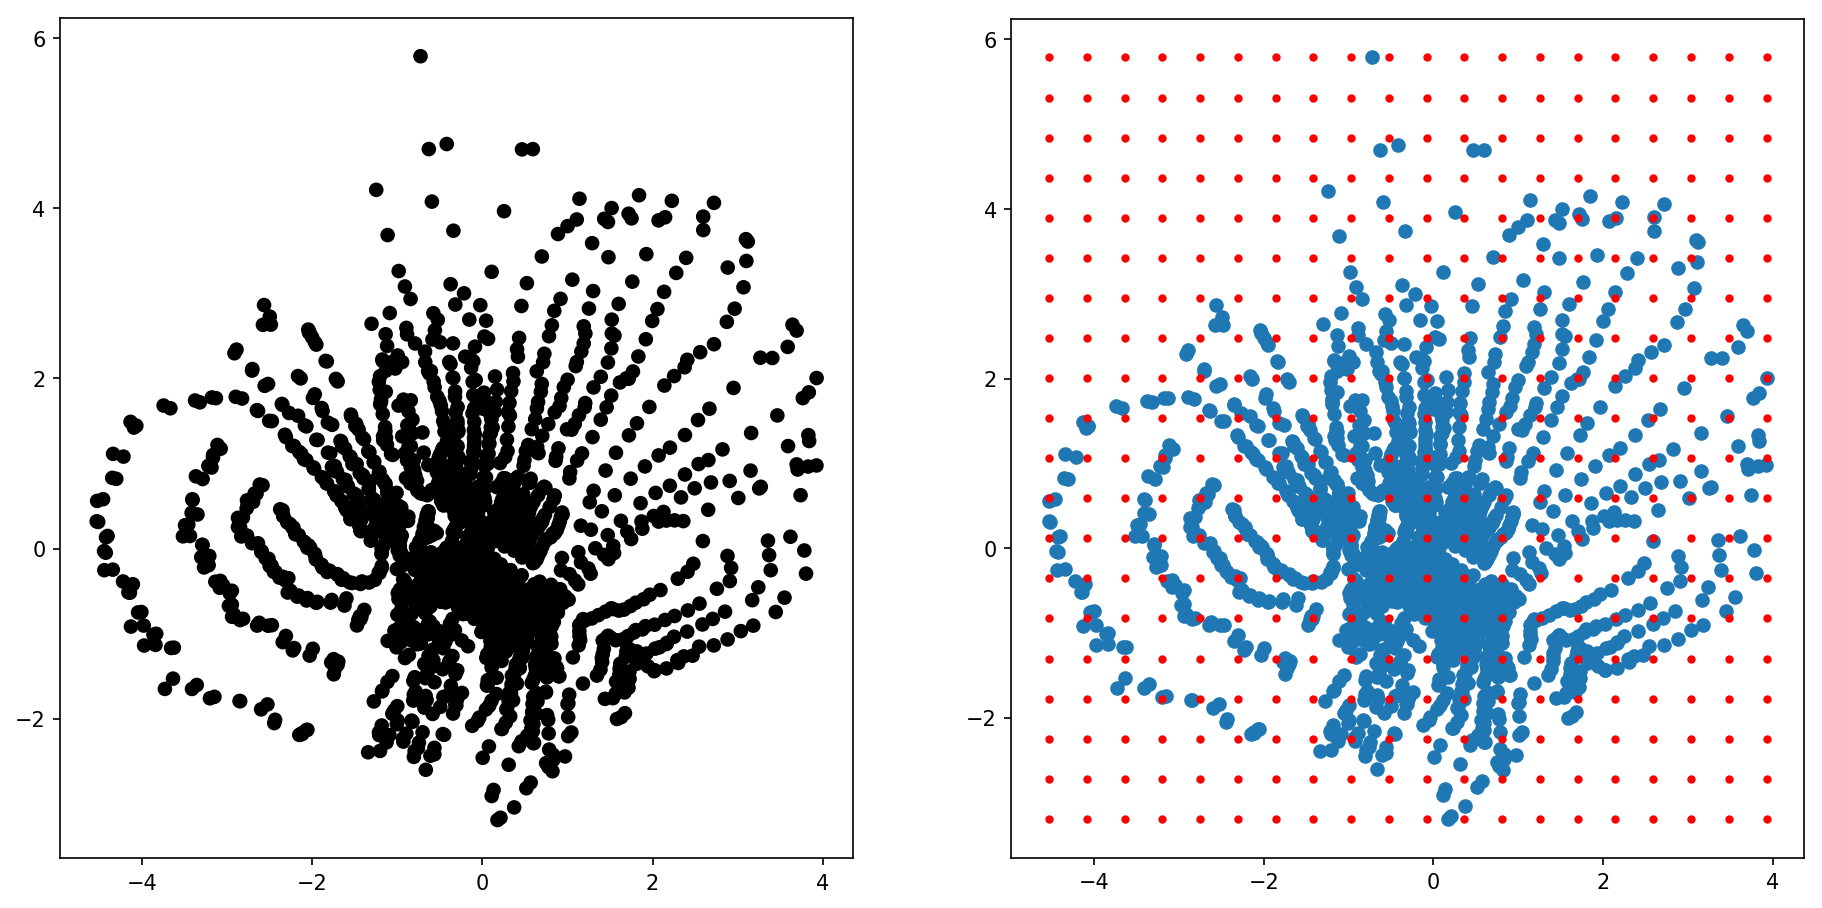

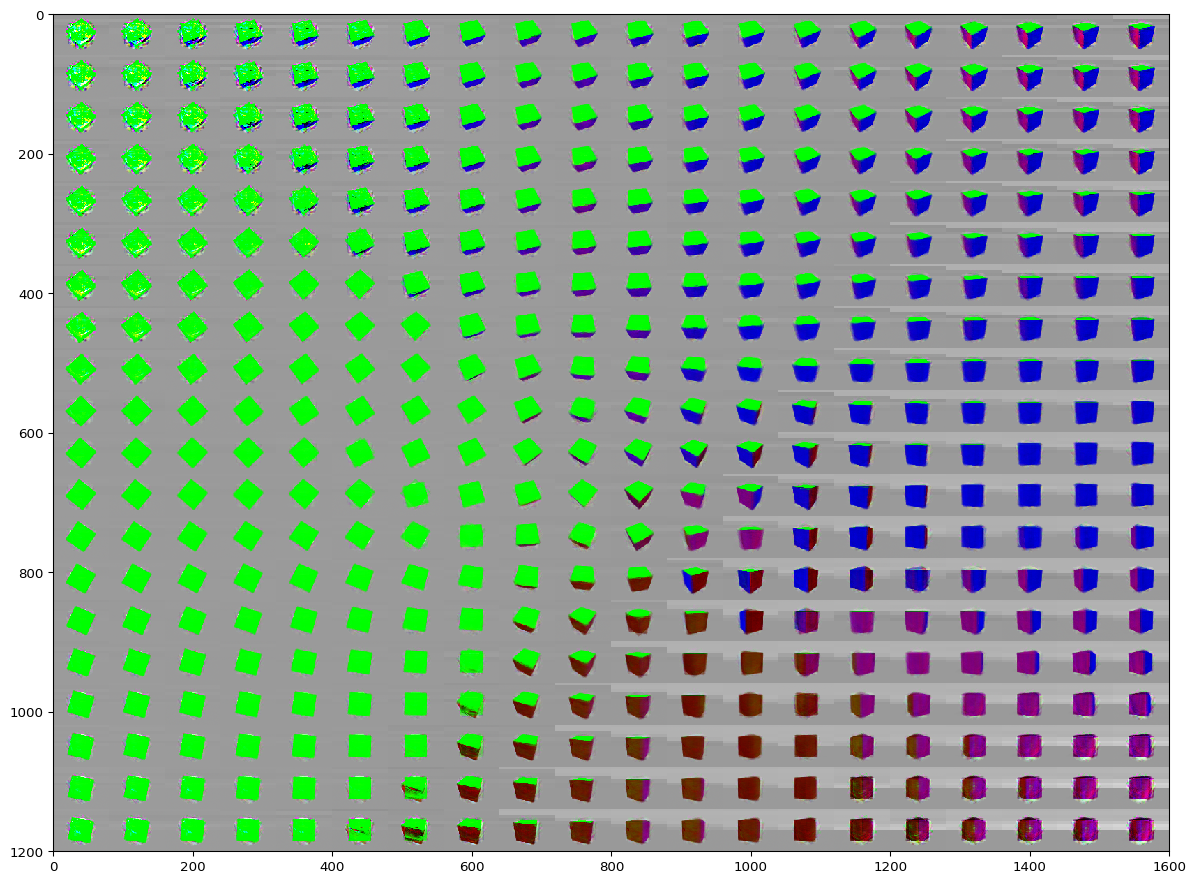

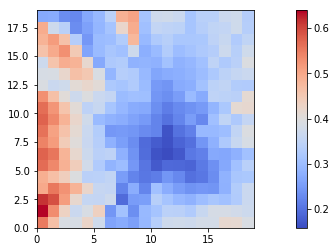

In [40]:
import vae_tools
from importlib import reload
reload(vae_tools)

# Vizualization
# Encode samples to get the min and max values in latent space
x_test_encoded = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train, batch_size=batch_size)

# display a 2D manifold
nx = 20
ny = 20

## linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
## to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.001, 0.999, nx))
grid_y = norm.ppf(np.linspace(0.001, 0.999, ny))
grid_x = np.linspace(np.amin(grid_x), np.amax(grid_x), nx)
grid_y = np.linspace(np.amin(grid_y), np.amax(grid_y), ny)
grid_x = np.linspace(np.amin(x_test_encoded[:, 0]), np.amax(x_test_encoded[:, 0]), nx)
grid_y = np.linspace(np.amin(x_test_encoded[:, 1]), np.amax(x_test_encoded[:, 1]), ny)

# display a 2D plot of the digit classes in the latent space
import vae_tools
from importlib import reload  # Python 3.4+ only.
viz = reload(vae_tools.viz)
vae_tools.viz.scatter_encoder(X_train, np.zeros((len(X_train),3)), grid_x, grid_y, model_obj, figsize=(15, 15), dpi=150)

# Plot the resampled inputs
figure, x_mean_test_encoded, x_std_test_encoded = viz.get_image_dec_enc_samples(grid_x, grid_y, model_obj, image_rows_cols_chns)
plt.figure(figsize=(15, 15), dpi=96)
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Plot the resampled std deviations
X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
plt.pcolor(X, Y, x_std_test_encoded, cmap='coolwarm', vmin=x_std_test_encoded.min(), vmax=x_std_test_encoded.max())
plt.colorbar()
plt.axis("image")
plt.show()

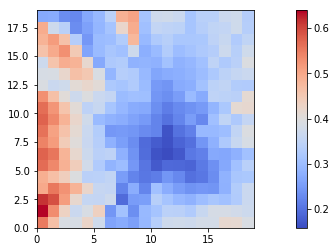

(20, 20)
(20, 20)


In [64]:
# Plot the resampled std deviations
X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
plt.pcolor(X, Y, x_std_test_encoded, cmap='coolwarm', vmin=x_std_test_encoded.min(), vmax=x_std_test_encoded.max())
plt.colorbar()
plt.axis("image")
plt.show()
print(X.shape)
print(x_std_test_encoded.shape)

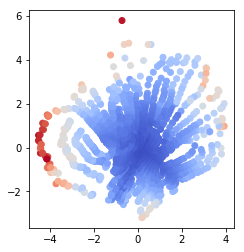

In [74]:
# Plot the resampled std deviations
#X, Y = np.meshgrid(np.arange(0,len(grid_x)), np.arange(0,len(grid_y)))
x_encoded_logvar = model_obj.get_encoder_logvar([encoder[0][0]]).predict(X_train, batch_size=batch_size)
#x_encoded_mean = model_obj.get_encoder_mean([encoder[0][0]]).predict(X_train, batch_size=batch_size)
#X, Y = np.meshgrid(x_encoded_mean[:,0], x_encoded_mean[:,1])
x_encoded_logvar_viz = np.sum(np.exp(x_encoded_logvar), axis = 1)
plt.scatter(x_encoded_mean[:,0], x_encoded_mean[:,1], c=x_encoded_logvar_viz, cmap='coolwarm', vmin=x_encoded_logvar_viz.min(), vmax=x_encoded_logvar_viz.max())
#plt.colorbar()
plt.axis("image")
plt.show()

In [49]:
print(np.sum(np.exp(x_encoded_logvar), axis = 1).shape)

(1710,)


In [62]:
X.shape

(1710, 1710)

In [10]:
np.ones((len(X_train),1)).shape

(1710, 1)